# Algorithmic Breakdown - LGSSM

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))

%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
from typing import NamedTuple
from jax.random import multivariate_normal, split
from tqdm.notebook import tqdm, trange
from jax.random import multivariate_normal
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
import jaxkf._src.lgssm as lgssm


import matplotlib.pyplot as plt

## Data

---
Like before, we can describe the dynamical system like so:

$$
\begin{aligned}
\mathbf{z}_{t+1} &= \mathbf{F}\mathbf{z}_t + \boldsymbol{\epsilon}_\mathbf{z} \\
x_t &= \mathbf{H}\mathbf{z}_t + \boldsymbol{\epsilon}_x
\end{aligned}
$$

We can manually define the terms, $\mathbf{F}$ and $\mathbf{H}$, which represent the relationship between the variables. Here they will be

$$
\begin{aligned}
\mathbf{F} &=
\begin{bmatrix}
1 & 1 \\ 0 & 1
\end{bmatrix} \\
\mathbf{H} &=
\begin{bmatrix}
1 & 0 
\end{bmatrix}
\end{aligned}
$$

Here, we assume that the state system is as follows:

$$
\begin{aligned}
\frac{\partial z^1}{\partial t} &= z^1 + z^2 \\
\frac{\partial z^2}{\partial t} &= z^1
\end{aligned}
$$

and we assume that the observation is related like so:

$$
x = z^1
$$

So essentially, we have an augmented the state space dimension, $\mathbf{z} \in \mathbb{R}^2$, which is higher than the observation space, $x \in \mathbb{R}^1$. Our assumption here is that there are higher order dynamics at play behind the scenes. 


#### Parameters

$$
\boldsymbol{\theta} = \{ \mathbf{F}, \mathbf{Q}, \mathbf{H}, \mathbf{R} \}
$$

## Parameters

#### LGSSM Params

In [45]:
class KFParams(NamedTuple):
    transition_matrix : jnp.ndarray
    transition_noise : jnp.ndarray
    observation_matrix : jnp.ndarray
    observation_noise : jnp.ndarray
    
class KFParamsDist(NamedTuple):
    transition_matrix: jnp.ndarray
    transition_noise_dist: tfd.Distribution
    observation_matrix: jnp.ndarray
    observation_noise_dist: tfd.Distribution


In [46]:
# initialize Kalman Filter
state_dim = 2
observation_dim = 1

# init transition model
transition_matrix = jnp.array([[1., 1.], [0., 1.]])   # state transition matrix
transition_noise = 1e-4 * jnp.eye((state_dim))                # state uncertainty

# check sizes
assert transition_matrix.shape == (state_dim, state_dim)
assert transition_noise.shape == (state_dim, state_dim)

# init emission model
observation_matrix = jnp.array([[1., 0.]])             # emission matrix
observation_noise = 50. * jnp.eye((1))                  # emission uncertainty

assert observation_matrix.shape == (observation_dim, state_dim)
assert observation_noise.shape == (observation_dim, observation_dim)


# Prior parameter distribution
mu0 = jnp.array([2.0, 0.0]).astype(float)
Sigma0 = jnp.eye(state_dim) * 1.0

assert mu0.shape == (state_dim,)
assert Sigma0.shape == (state_dim, state_dim)

In [47]:
observation_matrix.T.shape

(2, 1)

In [48]:

transition_noise_dist = tfd.MultivariateNormalFullCovariance(
    loc=jnp.zeros(state_dim), 
    covariance_matrix=transition_noise
)


observation_noise_dist = tfd.MultivariateNormalFullCovariance(
    loc=jnp.zeros(observation_dim), 
    covariance_matrix=observation_noise
)


params_dist = KFParamsDist(
    transition_matrix=transition_matrix, 
    transition_noise_dist=transition_noise_dist,
    observation_matrix=observation_matrix, 
    observation_noise_dist=observation_noise_dist
)

params = KFParams(
    transition_matrix=transition_matrix, 
    transition_noise=transition_noise,
    observation_matrix=observation_matrix, 
    observation_noise=observation_noise
)

#### KF State

In [49]:
class State(NamedTuple):
    mu_t: jnp.ndarray
    Sigma_t: jnp.ndarray
    t: int
    
class StatePrior(NamedTuple):
    prior: tfd.Distribution
    

In [50]:
prior_dist = tfd.MultivariateNormalFullCovariance(
    loc=mu0, 
    covariance_matrix=Sigma0
)

state_prior = StatePrior(prior=prior_dist)

In [51]:
prior_dist.covariance().shape, prior_dist.mean().shape

((2, 2), (2,))

## Demo States

In [52]:
from jaxkf._src.functional.sample import sample_step, sample_sequential, sample_sequential_vectorized, sample_event

In [53]:
# init keys - prior, steps
key = jax.random.PRNGKey(411)
key, key_init, key_step = jax.random.split(key, 3)

# initialize state mean
state_init = state_prior.prior.sample(seed=key_init)

assert state_init.shape == (state_dim,)

#### Sequential Sampling

In [54]:
# create time steps
num_time_steps = 100
time_steps = jnp.arange(num_time_steps)

# initialize keys for steps
key_steps = jax.random.split(key_step, num_time_steps)

# initialize states
state_samples, obs_samples = [], []

state = state_init

for i_step in tqdm(key_steps):
    
    # kalman step
    state, obs = sample_step(state, params_dist, i_step)
    
    # append
    state_samples.append(state)
    obs_samples.append(obs)
    

# concatenate all samples
state_samples = jnp.vstack(state_samples)
obs_samples = jnp.vstack(obs_samples)

  0%|          | 0/100 [00:00<?, ?it/s]

##### Scan Fn

In [55]:
# use the scan function
state_samples_, obs_samples_ = sample_sequential(prior_dist, params_dist, key_step, num_time_steps)

# check the shapes
assert state_samples_.shape == (num_time_steps, state_dim)
assert obs_samples_.shape == (num_time_steps, observation_dim)


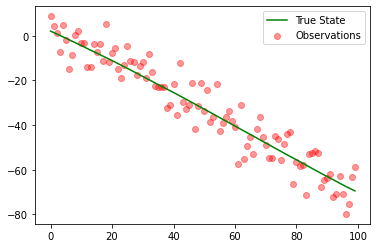

In [56]:
fig, ax = plt.subplots()

ax.plot(time_steps, state_samples[:, 0], label="True State", color="green")
ax.scatter(time_steps, obs_samples, label="Observations", color="red", alpha=0.4)

plt.legend()
plt.show()

#### Vectorized Sampling

In [141]:
%%time

num_samples = 100
num_time_steps = 50
key = 314
sample_prior = False

state_samples, obs_samples = sample_sequential_vectorized(
    prior_dist, 
    params_dist, 
    seed=key, 
    num_samples=num_samples, 
    num_time_steps=num_time_steps,
    sample_prior=sample_prior
)

CPU times: user 1.41 s, sys: 23.3 ms, total: 1.43 s
Wall time: 1.43 s


In [58]:
# check shapes
assert state_samples.shape == (num_samples, num_time_steps, state_dim)
assert obs_samples.shape == (num_samples, num_time_steps, observation_dim)

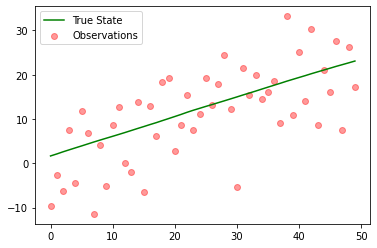

In [59]:
fig, ax = plt.subplots()

t_axes = jnp.arange(num_time_steps)

ax.plot(t_axes, state_samples[0, :, 0], label="True State", color="green")
ax.scatter(t_axes, obs_samples[0, :, 0], label="Observations", color="red", alpha=0.4)

plt.legend()
plt.show()

## Filtering

In [60]:
from jaxkf._src.functional.filter import kalman_step, filter_step_sequential, forward_filter

In [61]:
# init prior state
# state_init = State(
#     mu_t=state_prior.prior.mean(),
#     Sigma_t=state_prior.prior.covariance(),
#     t=0
# )
state_init = (
    state_prior.prior.mean(),
    state_prior.prior.covariance(),
    0
)

### Sequential Filtering

In [62]:
# create time steps
num_time_steps = 100
time_steps = jnp.arange(num_time_steps)


# initialize states
all_states = {"obs": [], "states": []}

state = state_init

for i_obs in tqdm(obs_samples[0]):
    
    # kalman step
    state = kalman_step(i_obs, state, params)
    
    # append
    all_states["obs"].append(i_obs)
    all_states["states"].append(state)
    

# # concatenate all samples
# state_samples = jnp.vstack(state_samples)
# obs_samples = jnp.vstack(obs_samples)

  0%|          | 0/50 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 3)

In [63]:
# pred_states = [(istate.mu_t, state.Sigma_t, istate.t) for istate in all_states["states"]]
mus, sigmas, ts = zip(*all_states["states"])

mus = jnp.vstack(mus)
sigmas = jnp.vstack(sigmas)
ts = jnp.vstack(ts)

ValueError: too many values to unpack (expected 3)

In [64]:
mus.shape, sigmas.shape, ts.shape

((10, 50, 2), (10, 50, 2, 2), (10, 50))

ValueError: x and y must be the same size

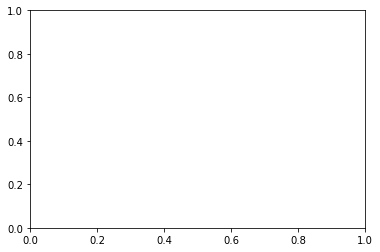

In [65]:
fig, ax = plt.subplots()


ax.scatter(ts[..., 0], all_states["obs"], color="red", label="Observations")
ax.plot(ts[..., 0], mus[:, 0], label="State (Filtered)", linestyle="--")

ax.set(xlabel="Time", ylabel="Signal")

plt.legend()
plt.show()


#### Sequential (Scan)

In [66]:
# init prior state
state_init = State(
    mu_t=state_prior.prior.mean(),
    Sigma_t=state_prior.prior.covariance(),
    t=0
)
# state_init = (
#     state_prior.prior.mean(),
#     state_prior.prior.covariance(),
#     0
# )
# init params
params = KFParams(
    transition_matrix=transition_matrix, 
    transition_noise=transition_noise,
    observation_matrix=observation_matrix, 
    observation_noise=observation_noise
)

In [67]:
%%time

# perform the filtering sequentially
mus, sigmas, log_likelihoods, mu_cond, Sigmas_cond, ts = filter_step_sequential(obs_samples[0], state_prior, params)

CPU times: user 285 ms, sys: 6.43 ms, total: 291 ms
Wall time: 289 ms


In [68]:
ts.shape, mus.shape

((50,), (50, 2))

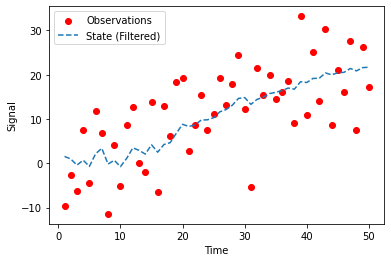

In [69]:
fig, ax = plt.subplots()


ax.scatter(ts, obs_samples[0], color="red", label="Observations")
ax.plot(ts, mus[:, 0], label="State (Filtered)", linestyle="--")

ax.set(xlabel="Time", ylabel="Signal")

plt.legend()
plt.show()


### Vectorized

In [70]:
state_prior

StatePrior(prior=<tfp.distributions.MultivariateNormalFullCovariance 'MultivariateNormalFullCovariance' batch_shape=[] event_shape=[2] dtype=float32>)

In [71]:
mus, sigmas, log_likelihoods, mu_cond, Sigmas_cond, ts = forward_filter(obs_samples, state_prior, params)

mus.shape, sigmas.shape, ts.shape

((10, 50, 2), (10, 50, 2, 2), (10, 50))

In [26]:
- jnp.mean(log_likelihoods[0], axis=-1)

DeviceArray(3.4174175, dtype=float32)

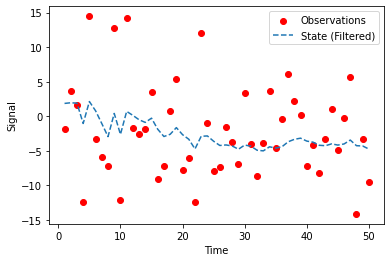

In [27]:
fig, ax = plt.subplots()

batch_idx = 3

ax.scatter(ts[batch_idx], obs_samples[batch_idx], color="red", label="Observations")
ax.plot(ts[batch_idx], mus[batch_idx, :, 0], label="State (Filtered)", linestyle="--")

ax.set(xlabel="Time", ylabel="Signal")

plt.legend()
plt.show()

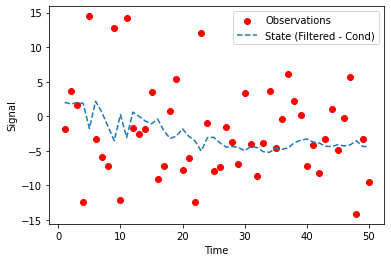

In [28]:
fig, ax = plt.subplots()

batch_idx = 3

ax.scatter(ts[batch_idx], obs_samples[batch_idx], color="red", label="Observations")
ax.plot(ts[batch_idx], mu_cond[batch_idx, :, 0], label="State (Filtered - Cond)", linestyle="--")

ax.set(xlabel="Time", ylabel="Signal")

plt.legend()
plt.show()

## Training (Optax)

In [188]:
import treex as tx

In [245]:
class LGSSM(tx.Module):
    # define free and fixed params
    transition_matrix: tx.Parameter.node()
    transition_noise: tx.Parameter.node()
    emission_matrix: tx.Parameter.node()
    emission_noise: tx.Parameter.node()
    prior_mean: tx.State.node()
    prior_cov: tx.State.node()
    
    def __init__(self, state_prior, params):
        # init prior
        self.prior_mean = state_prior.prior.mean()
        self.prior_cov = state_prior.prior.covariance()
        
        # init parameters
        self.transition_matrix = params.transition_matrix
        self.transition_noise = params.transition_noise
        self.emission_matrix = params.observation_matrix
        self.emission_noise = params.observation_noise
    
    def __call__(self, obs):
        """Do filtering operation"""
        
        prior_dist = tfd.MultivariateNormalFullCovariance(
            loc=self.prior_mean, 
            covariance_matrix=self.prior_cov
        )

        state_prior = StatePrior(prior=prior_dist)
        
        kf_params = KFParams(
            transition_matrix=self.transition_matrix,
            transition_noise=self.transition_noise,
            observation_matrix=self.emission_matrix,
            observation_noise=self.emission_noise
        )
        
        state = forward_filter(obs, state_prior, kf_params)
        
        mus, sigmas, log_likelihoods, *_ = state
        
        return mus, sigmas, log_likelihoods
    
    def filter_forward(self, obs):
        
        # create new params
        state = forward_filter(obs_samples, state_prior, params)
    
        mus, sigmas, log_likelihoods, *_ = state
        
        return mus, sigmas
    
    def log_prob(self, obs):
        
        state = self.__filter_forward(obs)
        
        mus, sigmas, log_likelihoods, *_ = state
        
        return log_likelihoods
    
    
#     def __filter_forward(self, obs):
        
#         prior_dist = tfd.MultivariateNormalFullCovariance(
#             loc=self.prior_mean, 
#             covariance_matrix=self.prior_cov
#         )

#         state_prior = StatePrior(prior=prior_dist)
        
#         params = KFParams(
#             transition_matrix=self.transition_matrix,
#             transition_noise=self.transition_noise,
#             observation_matrix=self.emission_matrix,
#             observation_noise=self.emission_noise
#         )
        
        
#         return 

In [246]:
params.observation_matrix.shape

(1, 2)

In [247]:
# random params
params_rand = KFParams(
    transition_matrix=jnp.ones((state_dim, state_dim)),
    transition_noise=jnp.ones((state_dim, state_dim)),
    observation_matrix=jnp.ones((observation_dim, state_dim)),
    observation_noise=jnp.ones(observation_dim),
)


# initialize model
kf_model = LGSSM(state_prior, params_rand)

# init model
kf_model = kf_model.init(42)

# 

In [248]:
model_params = kf_model.parameters()

### Loss

In [249]:
# differentiate only w.r.t. parameters
def loss_fn(params, model, x):
    # merge params into model
    model = model.merge(params)

    # forward transformation
    *_, log_prob = model(x)
    
    
    log_prob = log_prob.sum(axis=0)
    
    # calculate nll
    loss = - jnp.mean(log_prob)

    # the model may contain state updates
    # so it should be returned
    return loss, model

In [250]:
loss, kf_model = loss_fn(model_params, kf_model, obs_samples)
loss

DeviceArray(468.596, dtype=float32)

#### Train Step

In [251]:
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

In [252]:
(loss, m), grads = grad_fn(model_params, kf_model, obs_samples)

In [253]:
loss

DeviceArray(468.596, dtype=float32)

In [254]:
grads

LGSSM {
    emission_matrix: jaxlib.DeviceArray((1, 2), float32),
    emission_noise: jaxlib.DeviceArray((1,), float32),
    name: "lgssm",                                             str
    prior_cov: jaxlib.DeviceArray((2, 2), float32),
    prior_mean: jaxlib.DeviceArray((2,), float32),
    transition_matrix: jaxlib.DeviceArray((2, 2), float32),
    transition_noise: jaxlib.DeviceArray((2, 2), float32),
}

In [255]:
# both model and optimizer are jit-able
@jax.jit
def train_step(model, x, optimizer):
    # select only the parameters
    params = model.parameters()

    (loss, model), grads = grad_fn(params, model, x)

    # update params and model
    params = optimizer.update(grads, params)
    model = model.merge(params)

    # return new model and optimizer
    return loss, model, optimizer

### Optimizer

In [256]:
import optax
from tqdm.notebook import trange, tqdm

In [257]:
optimizer = tx.Optimizer(optax.adam(0.1)).init(kf_model)

In [258]:
n_iterations = 10
losses = []
batch_size = 64

train_data = obs_samples

with trange(n_iterations) as pbar:
    for i in pbar:
        
        loss, kf_model, optimizer = train_step(kf_model, train_data, optimizer)
        
        pbar.set_description(f"Loss: {loss:.4f}")
        losses.append(loss)

  0%|          | 0/10 [00:00<?, ?it/s]

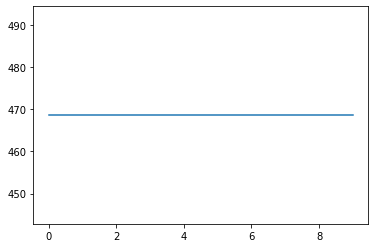

In [259]:
fig, ax = plt.subplots()

ax.plot(losses)

plt.show()

In [213]:
trained_params = kf_model.parameters()

In [159]:
trained_params.emission_matrix

DeviceArray([[1., 1.]], dtype=float32)

In [ ]:
# initialize Kalman Filter
state_dim = 2
observation_dim = 1

# init transition model
transition_matrix = jnp.array([[1., 1.], [0., 1.]])   # state transition matrix
transition_noise = 1e-4 * jnp.eye((state_dim))                # state uncertainty

# check sizes
assert transition_matrix.shape == (state_dim, state_dim)
assert transition_noise.shape == (state_dim, state_dim)

# init emission model
observation_matrix = jnp.array([[1., 0.]])             # emission matrix
observation_noise = 50. * jnp.eye((1))                  # emission uncertainty

assert observation_matrix.shape == (observation_dim, state_dim)
assert observation_noise.shape == (observation_dim, observation_dim)


# Prior parameter distribution
mu0 = jnp.array([2.0, 0.0]).astype(float)
Sigma0 = jnp.eye(state_dim) * 1.0

assert mu0.shape == (state_dim,)
assert Sigma0.shape == (state_dim, state_dim)

##

In [258]:


# initia
transition_noise_dist = lgssm.MultivariateNormal(jnp.zeros(state_dim), transition_noise)

observation_noise_dist = lgssm.MultivariateNormal(jnp.zeros(observation_dim), observation_noise)

initial_state_prior_dist = lgssm.MultivariateNormal(mu0, Sigma0)

kf_model = lgssm.LinearGaussianStateSpaceModel(
    transition_matrix, transition_noise_dist,
    observation_matrix, observation_noise_dist,
    initial_state_prior_dist
)

In [259]:
%%time

log_probs, mus, sigmas, mus_cond, sigmas_cond = kf_model.forward_filter(obs_samples[0])


mus.shape, sigmas.shape

CPU times: user 361 ms, sys: 6.23 ms, total: 367 ms
Wall time: 365 ms


((50, 2), (50, 2, 2))

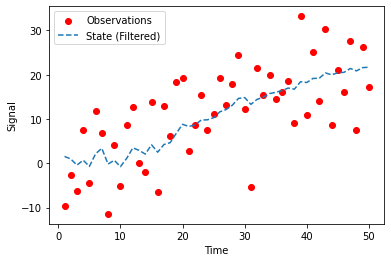

In [261]:
fig, ax = plt.subplots()


ax.scatter(ts[0], obs_samples[0], color="red", label="Observations")
ax.plot(ts[0], mus[:, 0], label="State (Filtered)", linestyle="--")

ax.set(xlabel="Time", ylabel="Signal")

plt.legend()
plt.show()

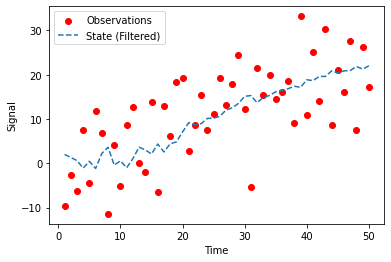

In [263]:
fig, ax = plt.subplots()


ax.scatter(ts[0], obs_samples[0], color="red", label="Observations")
ax.plot(ts[0], mus_cond[:, 0], label="State (Filtered)", linestyle="--")

ax.set(xlabel="Time", ylabel="Signal")

plt.legend()
plt.show()

In [19]:
state.shape, obs.shape

((2,), (1,))

In [20]:
# initialize states
all_states, all_obs = [], []

state = state_init

for i_step in tqdm(sample_keys):
    
    # kalman step
    state, (state, obs) = kf_model.sample_step(state, i_step)
    
    # append
    all_states.append(state)
    all_obs.append(obs)
    

all_states = jnp.vstack(all_states)
all_obs = jnp.vstack(all_obs)

NameError: name 'sample_keys' is not defined

TypeError: list indices must be integers or slices, not tuple

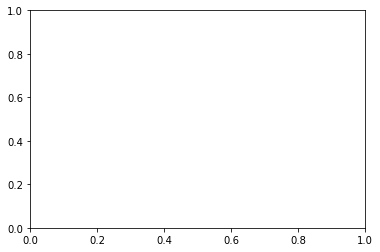

In [21]:
fig, ax = plt.subplots()

ax.plot(time_steps, all_states[:, 0], label="True State", color="green")
ax.scatter(time_steps, all_obs, label="Observations", color="red", alpha=0.4)

plt.legend()
plt.show()

In [112]:
num_time_steps = 100

all_states, all_obs = kf_model.sample(seed=123, sample_shape=10, num_timesteps=num_time_steps)
states.shape, all_obs.shape

((1, 100, 2), (10, 100, 1))

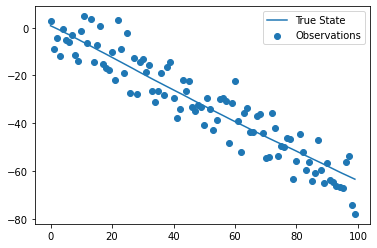

In [117]:
fig, ax = plt.subplots()

ax.plot(time_steps, all_states[3, :, 0], label="True State")
ax.scatter(time_steps, all_obs[3, :, 0], label="Observations")

plt.legend()
plt.show()

In [100]:
mu0.shape

(2,)

In [130]:
kf_model.sample_step(mu0, key)

(2,) (2, 1) (1,)


TypeError: dot_general requires contracting dimensions to have the same shape, got [1] and [2].

---

## Filtering

1. Do Forward Filter for a batch of inputs
2. Init prior mean, cov
3. Loop Through Kalman Step (mu0, cov0)

In [11]:
from jaxkf._src.functional.ops import kalman_step

In [14]:
num_time_steps = 15

states_preds, states_corrs = [], []

for i_t_step in trange(num_time_steps):
    
    # kalman step
    state_pred, state_corrected = kalman_step(
    
    pass

SyntaxError: invalid syntax (2776370347.py, line 12)

### Kalman Filter Step

### Predict Step

## Smoothing

### Posterior Marginals (Alternative)

## Log Probability

## Model

##### Initialize Parameters

In [12]:
kf_params = KFParams(
    F=F, R=R,
    H=H, Q=Q
)

## State

In [13]:
class State(NamedTuple):
    mu_t: jnp.ndarray
    Sigma_t: jnp.ndarray
    t: int

In [14]:
# init state
init_mean = jnp.array([2., 0.])
init_cov = jnp.eye(init_mean.shape[0])

assert init_mean.shape == (state_dim,)
assert init_cov.shape == (state_dim, state_dim)

##### Initialize

In [16]:
init_state = State(
    mu_t=init_mean,
    Sigma_t=init_cov,
    t=0
)

## Sampling



1. Sample from the initial state

$$
\mathbf{x_0} \sim \mathcal{N}(\boldsymbol{\mu}_0, \boldsymbol{\Sigma}_0; \text{key})
$$


In [24]:
key = jax.random.PRNGKey(314)


# sample from initial state
x0_key, key = split(key, 2)

state_t = multivariate_normal(key=x0_key, mean=init_mean, cov=init_cov)


In [ ]:
def sample_step(key, state, params, n_samples=1):
    
    xt_key, trans_key, obs_key = split(key, 3)
    
    # unroll state
    mu_t = init_state.mu_t
    sigma_t = init_state.Sigma_t
    
    # unroll params
    F = params.F
    R = params.R
    H = params.H
    Q = params.Q
    
    
    state_t = multivariate_normal(key=x0_key, mean=mu_t, cov=Sigma_0)
    
    # new state
    
    
    return key

In [25]:
def sample(key, init_state, params, n_samples=1):
    """Sample states"""
    , key = split(key, 2)
    
    mu_0 = init_state.mu_t
    Sigma_0 = init_state.Sigma_t
    t = init_state.t
    
    state_t = multivariate_normal(key=x0_key, mean=mu_0, cov=Sigma_0)
    
    
    pass

In [27]:
sample(key, init_state, kf_params)

## Code Layout



```python
class KFDist:
    def __init__(self):
        """Initialize the parameters"""
        pass
    
    def filter_states(self, obs):
        """Perform the filtering operation
        p(x_{1:T}|y_{1:T})
        """
        return None
    
    def log_prob(self, obs):
        """p(x_"""
        return None
    
    def rsample(self, n_samples):
        return None
    
```

### State

### Parameters

### Filter Function

In [ ]:
# mu_t, sigma_t, x_t

# get matrices
A = 

In [ ]:
def kalman_step(mu_t, sigma_t, x_t)

### Sample Function

### Training

In [ ]:
import numpyro
import numpyro.distributions

In [ ]:
def kf_model(obs):
    
    R = numpyro.sample("R", dist